In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import pydicom

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

root_path = '/content/drive/My Drive/'
files = os.listdir(root_path)
print(files[-1])

root_dir = os.path.join(root_path, 'train Data Files')
files = os.listdir(root_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
107 yoga poses


In [4]:
multiple_fracs_df = pd.read_excel('/content/drive/My Drive/fracatlas-DatasetNinja (1)/Multiple Fractures.xlsx')
multiple_fracs_list = multiple_fracs_df['Multiple_Fractures'].tolist()

In [ ]:


def convert_to_yolo_format(json_file, output_dir):
    with open(json_file, 'r') as f:
        data = json.load(f)

    image_width = data['size']['width']
    image_height = data['size']['height']
    objects = data['objects']

    yolo_annotations = []
    for obj in objects:
        if obj['geometryType'] == 'rectangle':
            class_id = 0  # Assuming the class ID for 'fractured' is 0
            x1, y1 = obj['points']['exterior'][0]
            x2, y2 = obj['points']['exterior'][1]

            # Calculate center coordinates, width, and height
            x_center = (x1 + x2) / 2 / image_width
            y_center = (y1 + y2) / 2 / image_height
            width = (x2 - x1) / image_width
            height = (y2 - y1) / image_height

            yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")

        elif obj['geometryType'] == 'polygon':
            # Convert polygon to bounding box
            x_coords = [point[0] for point in obj['points']['exterior']]
            y_coords = [point[1] for point in obj['points']['exterior']]
            x1, y1 = min(x_coords), min(y_coords)
            x2, y2 = max(x_coords), max(y_coords)

            class_id = 0  # Assuming the class ID for 'fractured' is 0

            # Calculate center coordinates, width, and height
            x_center = (x1 + x2) / 2 / image_width
            y_center = (y1 + y2) / 2 / image_height
            width = (x2 - x1) / image_width
            height = (y2 - y1) / image_height

            yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")

    # Save YOLO annotations to a .txt file
    output_file = os.path.join(output_dir, os.path.basename(json_file).replace('.jpg.json', '.txt'))
    with open(output_file, 'w') as f:
        f.write('\n'.join(yolo_annotations))
    print(f"Converted annotations saved to {output_file}")

def preprocess_images(input_dir, output_dir, target_size=(640, 640)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error loading image: {image_path}")
                continue

            # Resize image
            image_resized = cv2.resize(image, target_size)

            # Convert to grayscale
            image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

            # Apply Gaussian blur to reduce noise
            image_blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)

            # Apply Laplacian filter for edge detection with increased kernel size
            laplacian = cv2.Laplacian(image_blurred, cv2.CV_64F, ksize=3)
            laplacian = cv2.convertScaleAbs(laplacian)  # Convert back to 8-bit image

            # Apply thresholding to make edges more distinct
            _, edges_thresh = cv2.threshold(laplacian, 30, 255, cv2.THRESH_BINARY)

            # Convert edges back to 3 channels
            edges_colored = cv2.cvtColor(edges_thresh, cv2.COLOR_GRAY2BGR)

            # Blend the original image with the edge-detected image
            alpha = 0.7  # Increase the weight of the original image
            beta = 0.3   # Decrease the weight of the edge-detected image
            image_blended = cv2.addWeighted(image_resized, alpha, edges_colored, beta, 0)

            # Normalize image to range [0, 1]
            image_normalized = image_blended / 255.0

            # Save the preprocessed image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, (image_normalized * 255).astype(np.uint8))

            print(f"Preprocessed and saved: {output_path}")

# Example usage
json_annotation_dirs = {
    'train': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/annotations (1)/train (1)',
    'val': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/annotations (1)/val (1)',
    'test': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/annotations (1)/test (1)'
}

image_dirs = {
    'train': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/train_img',
    'val': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/val_img',
    'test': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/test_img/'
}

label_dirs = {
    'train': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/train',
    'val': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/val',
    'test': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/test'
}

image_output_dirs = {
    'train': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/images/train',
    'val': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/images/val',
    'test': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/images/test'}

image_one_frac_output_dirs = {
    'train': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/images/train_one_frac',
    'val': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/images/val_one_frac',
    'test': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/images/test_one_frac'
}

label_one_frac_output_dirs = {
    'train': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/train_one_frac',
    'val': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/val_one_frac',
    'test': '/content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/test_one_frac'
}

multiple_fractures = True #Make false if you don't want to remove multiple fractures

if multiple_fractures == False:
  for split in ['train', 'val', 'test']:
      for filename in os.listdir(json_annotation_dirs[split]):
          if filename.endswith('.json') and filename[:14] not in multiple_fracs_list:
              json_file = os.path.join(json_annotation_dirs[split], filename)
              convert_to_yolo_format(json_file, label_one_frac_output_dirs[split])

      preprocess_images(image_dirs[split], image_one_frac_output_dirs[split])
else:
    for split in ['train', 'val', 'test']:
      for filename in os.listdir(json_annotation_dirs[split]):
          if filename.endswith('.json'):
              json_file = os.path.join(json_annotation_dirs[split], filename)
              convert_to_yolo_format(json_file, label_dirs[split])

      preprocess_images(image_dirs[split], image_output_dirs[split])

Converted annotations saved to /content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/train/IMG0000143.txt
Converted annotations saved to /content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/train/IMG0000057.txt
Converted annotations saved to /content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/train/IMG0000100.txt
Converted annotations saved to /content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/train/IMG0000058.txt
Converted annotations saved to /content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/train/IMG0000019.txt
Converted annotations saved to /content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/train/IMG0000142.txt
Converted annotations saved to /content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/train/IMG0000059.txt
Converted annotations saved to /content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/train/IMG0000044.txt
Converted annotations saved to /content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/train/IMG0000025.txt
Converted 

In [5]:
def rename_label_files(label_dir):
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.jpg.txt')]
    for label_file in label_files:
        new_label_file = label_file.replace('.jpg.txt', '.txt')
        os.rename(os.path.join(label_dir, label_file), os.path.join(label_dir, new_label_file))
        print(f"Renamed {label_file} to {new_label_file}")

# Define label directories
train_label_dir = '/content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/train'
val_label_dir = '/content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/val'
test_label_dir = '/content/drive/My Drive/fracatlas-DatasetNinja (1)/labels/test'

# Rename label files
rename_label_files(train_label_dir)
rename_label_files(val_label_dir)
rename_label_files(test_label_dir)

## Creating Yammel

In [6]:
import os

def create_yaml_file(train_img_dir, val_img_dir, test_img_dir, nc, class_names, output_path):
    yaml_content = f"""
train: {train_img_dir}
val: {val_img_dir}
test: {test_img_dir}

nc: {nc}

names: {class_names}
"""
    with open(output_path, 'w') as file:
        file.write(yaml_content)
    print(f"YAML file created at: {output_path}")

# Define directories
train_image_dir = '/content/drive/My Drive/fracatlas-DatasetNinja (1)/images/train' # DELETE one_frac IF YOU WANT TO INCLUDE MULTIPLE FRACTURES
val_image_dir = '/content/drive/My Drive/fracatlas-DatasetNinja (1)/images/val' # DELETE one_frac IF YOU WANT TO INCLUDE MULTIPLE FRACTURES
test_image_dir = '/content/drive/My Drive/fracatlas-DatasetNinja (1)/images/test' # DELETE one_frac IF YOU WANT TO INCLUDE MULTIPLE FRACTURES



# Number of classes and class names
nc = 2
class_names = ['fractured', 'Not fractured']  # List of class names

# Output YAML file path
output_path = '/content/drive/My Drive/fracatlas-DatasetNinja (1)/YOLO_new_model_v2.yaml'

# Create YAML file
create_yaml_file(train_image_dir, val_image_dir, test_image_dir, nc, class_names, output_path)

YAML file created at: /content/drive/My Drive/fracatlas-DatasetNinja (1)/YOLO_new_model_v2.yaml


In [ ]:
!rm -rf /content/drive/My\ Drive/fracatlas-DatasetNinja\ (1)/images/train.cache
!rm -rf /content/drive/My\ Drive/fracatlas-DatasetNinja\ (1)/images/val.cache
!rm -rf /content/drive/My\ Drive/fracatlas-DatasetNinja\ (1)/images/test.cache

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `rm -rf /content/drive/My\ Drive/fracatlas-DatasetNinja\ (1)/images/train.cache'
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `rm -rf /content/drive/My\ Drive/fracatlas-DatasetNinja\ (1)/images/val.cache'
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `rm -rf /content/drive/My\ Drive/fracatlas-DatasetNinja\ (1)/images/test.cache'


In [7]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install dependencies
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16836, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 16836 (delta 1), reused 6 (delta 0), pack-reused 16825
Receiving objects: 100% (16836/16836), 15.58 MiB | 9.98 MiB/s, done.
Resolving deltas: 100% (11545/11545), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5

In [7]:
%cd /content/yolov5

# Train the YOLOv5 model
!python train.py --img 640 --batch 8 --epochs 100 --data "/content/drive/My Drive/fracatlas-DatasetNinja (1)/YOLO_new_model_v2.yaml" --cfg yolov5s.yaml --weights yolov5s.pt --name custom_yolov5


/content/yolov5
2024-08-04 14:30:08.506507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 14:30:08.527455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 14:30:08.533879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=/content/drive/My Drive/fracatlas-DatasetNinja (1)/YOLO_new_model_v2.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, b

In [ ]:
%cd /content/yolov5/runs/train/custom_yolov5
!ls

/content/yolov5/runs/train/custom_yolov5
confusion_matrix.png				    PR_curve.png	   val_batch0_pred.jpg
events.out.tfevents.1722697687.55d598745e6f.8317.0  R_curve.png		   val_batch1_labels.jpg
F1_curve.png					    results.csv		   val_batch1_pred.jpg
hyp.yaml					    results.png		   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	   val_batch2_pred.jpg
labels.jpg					    train_batch1.jpg	   weights
opt.yaml					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


/content/yolov5/runs/train/custom_yolov53


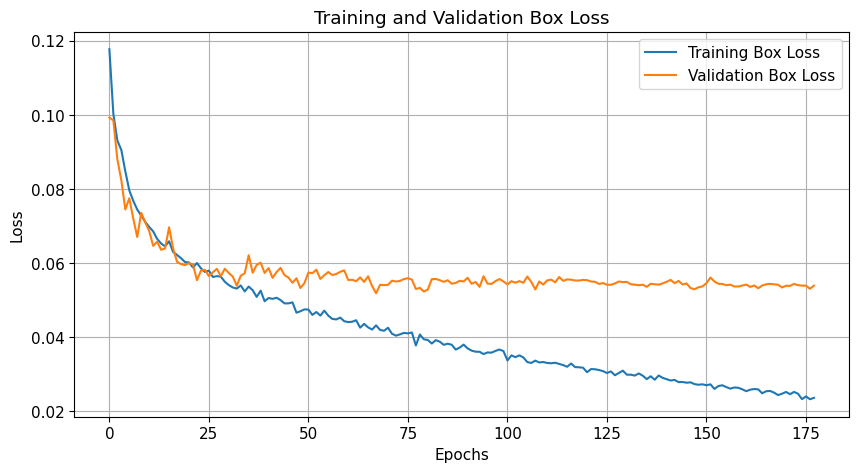

In [ ]:
%cd /content/yolov5/runs/train/custom_yolov53
import matplotlib.pyplot as plt
%matplotlib inline



# Load the results.csv file
results_df = pd.read_csv('results.csv')
results_df.columns = results_df.columns.str.strip()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Training Box Loss')
plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Validation Box Loss')


# Customize the plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Box Loss')
plt.legend()
plt.grid(True)
plt.show()

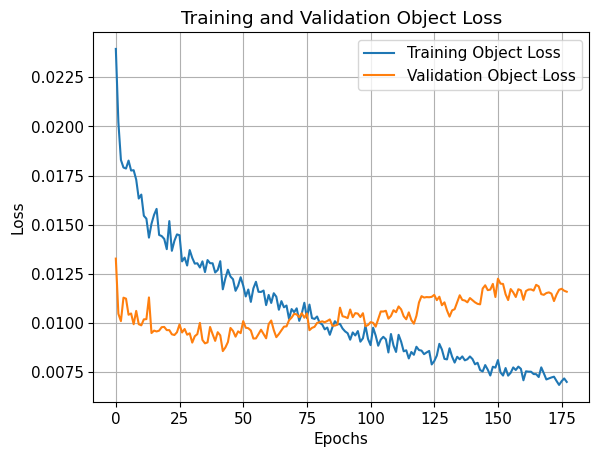

In [ ]:
plt.plot(results_df['epoch'], results_df['train/obj_loss'], label='Training Object Loss')
plt.plot(results_df['epoch'], results_df['val/obj_loss'], label='Validation Object Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Object Loss')
plt.legend()
plt.grid(True)
plt.show()

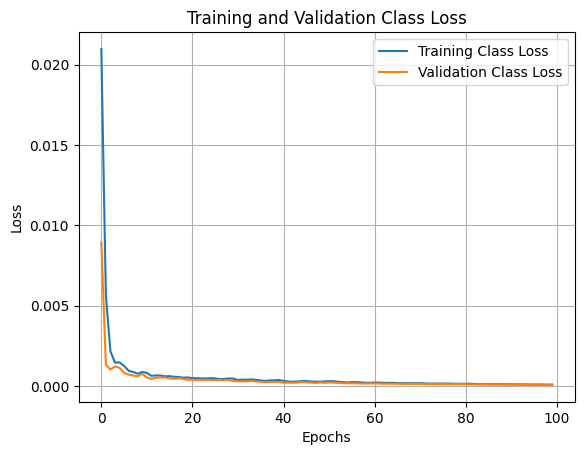

In [ ]:
plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Training Class Loss')
plt.plot(results_df['epoch'], results_df['val/cls_loss'], label='Validation Class Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Class Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os

weights_dir = '/content/yolov5/runs/train/custom_yolov5/weights'
# List the contents of the weights directory
if os.path.exists(weights_dir):
    print("Directory contents:")
    print(os.listdir(weights_dir))
else:
    print(f"Directory {weights_dir} does not exist.")

Directory contents:
['best.pt', 'last.pt']


In [ ]:
import torch

# Correct path to the weights file
weights_path = '/content/yolov5/runs/train/custom_yolov52/weights/Yolo_fracture_detection_model.pt'

# Check if the file exists
if os.path.exists(weights_path):
    # Load the trained model
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path)
else:
    print("Weights file not found. Please check the training process and the file path.")

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-7-29 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
